In [1]:
# Imports
import numpy as np 
import pandas as pd
from sklearn.metrics import confusion_matrix
from random import random
import seaborn as sn
import matplotlib.pyplot as plt
import math
import scipy

%matplotlib inline

In [2]:
# Read in the data
x_train = pd.read_csv('data/X_train.csv', header = None)
y_train = pd.read_csv('data/y_train.csv', header = None)
x_test= pd.read_csv('data/X_test.csv', header = None)
y_test = pd.read_csv('data/y_test.csv', header = None)

# Naive Bayes

We will use 54 Bernoulli distributions for the 54 binary dimensions and 3 Pareto distributions for the last 3 poisitive dimensions. I choose the Pareto distribution because it is able to model outliers more easily, which the data seems to have many of.

In [3]:
def get_bernoulli_prob(x, param):
    """Bernoulli probability density function

    Parameters
    ----------
    x : {array-like, sparse matrix},
    shape = [n_samples, n_features]
        data
        
    param : float
        Probability of "success"
        
    Returns
    ----------
    bernoulli_prob : float
        Bernoulli probability
    """  
    bernoulli_prob = (param**x) * (1-param)**(1-x)
    return bernoulli_prob

In [4]:
def get_pareto_prob(x, param):
    """Pareto probability density function

    Parameters
    ----------
    x : {array-like, sparse matrix},
    shape = [n_samples, n_features]
        data
        
    param : float
        Pareto distribution parameter
        
    Returns
    ----------
    pareto_prob : float
        Pareto probability
    """  
    pareto_prob = param * (x**(-1*(param + 1)))
    return pareto_prob

In [5]:
class NaiveBayes(object):
    """Naive Bayes Classifier
    
    Parameters
    ----------        
    x_train : {array-like, sparse matrix},
    shape = [n_samples, n_features]
        Training data
    
    y_train : array-like, shape = [n_samples]
        Training targets
    
    num_classes : integer
        Number of classes
    """
    def __init__(self, x_train, y_train, num_classes):
        self.values_per_class = [x_train[y_train[0] == i] for i in range(num_classes)]
        self.amount_per_class = [len(self.values_per_class[i]) for i in range(len(self.values_per_class))]
        self.total = len(y_train)
        
    def find_parameters(self):
        """Find the probability parameters for each class
        
        """
        self.probability_params = {}
        for i in range(len(self.values_per_class)):
            params = self.values_per_class[i].mean()
            pareto_num = len(self.values_per_class[i])
            pareto_denom = (np.log(self.values_per_class[i][list(self.values_per_class[i].columns[54:57])]).sum())
            params.update(pareto_num/pareto_denom)
            self.probability_params[i] = params

    def get_probabilities(self, input_vec):
        """Calculate the probabilities of classes using the features of the input vector
        
        input_vec : {array-like, sparse matrix},
        shape = [1, n_features]
            Input vector
            
        Returns
        ----------
        probabilities : list[float]
            Probabilities per class of the input vector
        """
        probabilities = []
        class_num = 0
        for class_val, param in self.probability_params.items():
            probability = self.amount_per_class[class_num]/self.total # CHANGE TO USE CLASS PROBABILITY
            for i in range(len(param)):
                if i < 54:
                    probability *= get_bernoulli_prob(input_vec[i], param[i])
                else:
                    probability *= get_pareto_prob(input_vec[i], param[i])
            probabilities.append(probability)
            class_num += 1
        return probabilities
    
    def predict_single(self, input_vec):
        """Make a single prediction
        
        input_vec : {array-like, sparse matrix},
        shape = [1, n_features]
            Input vector
            
        Returns
        ----------
        prediction : integer
            Predicted class
        """
        probabilities = self.get_probabilities(input_vec)
        prediction = probabilities.index(max(probabilities))
        return prediction
    
    def predict(self, test_set):
        """Make predictions on the entire test set
        
        test_set : {array-like, sparse matrix},
        shape = [n_samples, n_features]
            Test set to make predictions on
            
        Returns
        ----------
        predictions : List[integer]
            List of predicted classes for each point in the testset
        """
        predictions = [self.predict_single(feature_vec[1]) for feature_vec in test_set.iterrows()]
        return predictions

    def accuracy(self, predictions, y_test):
        """Get the accuracy and errors
        
        predictions : List[integer],
            List of predicted classes
            
        y_test : array-like, shape = [n_samples]
            Actual classes
            
        Returns
        ----------
        (Integer, confusion_matrix)
            Accuracy, confusion matrix
        """
        prediction_matrix = confusion_matrix(y_test, predictions, labels = [0, 1])
        accuracy = np.diagonal(prediction_matrix).sum()/len(predictions)*100
        return (accuracy, prediction_matrix)
        

In [6]:
# Train the model
naive_bayes = NaiveBayes(x_train, y_train, 2)
naive_bayes.find_parameters()

In [7]:
# Make predictions on the test set
predictions = naive_bayes.predict(x_test)
accuracy, matrix = naive_bayes.accuracy(predictions, y_test)

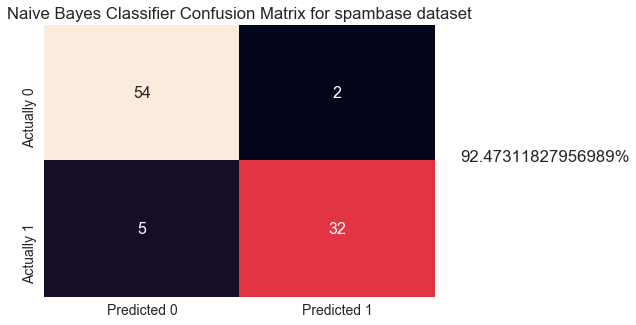

In [8]:
# Plot the confusion Matrix
condusion_matrix = pd.DataFrame(matrix, range(2), range(2))
plt.figure(figsize = (7,5))
sn.set(font_scale=1.4)
sn.heatmap(condusion_matrix, annot=True, annot_kws={"size": 16}, cbar = False, 
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels = ['Actually 0', 'Actually 1'])
plt.figtext(.95, .5, '{0}%'.format(accuracy), rotation='horizontal')
plt.title('Naive Bayes Classifier Confusion Matrix for spambase dataset');

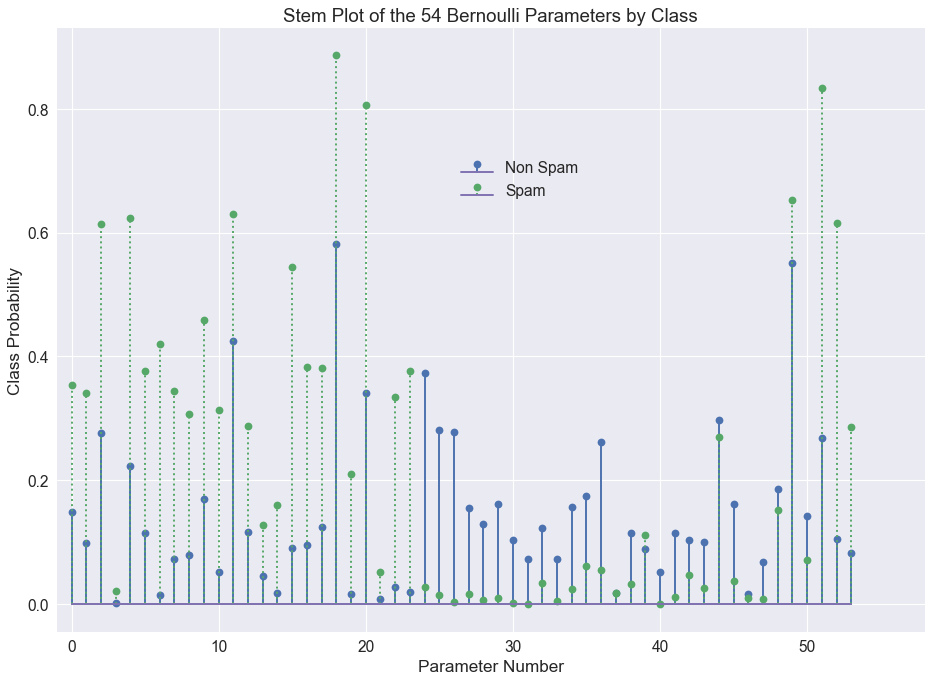

In [9]:
# Stem Plot to visuaize features
plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
markerline, stemlines, baseline = plt.stem(naive_bayes.probability_params[0][:54], markerfmt='o', label='Non Spam')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
markerline, stemlines, baseline = plt.stem(naive_bayes.probability_params[1][:54], markerfmt='o', label='Spam')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
plt.setp(stemlines, 'linestyle', 'dotted')
plt.legend(loc='center left', bbox_to_anchor=(.45, 0.75))
plt.title('Stem Plot of the 54 Bernoulli Parameters by Class')
plt.xlabel('Parameter Number')
plt.ylabel('Class Probability')
plt.xlim([-1,58]);

## Nearest Neighbors

In [10]:
def manhattan_distance(vec1, vec2):
    """Compute the manhattan distance between two vectors

    Parameters
    ----------
    vec1 : {array-like, sparse matrix},
    shape = [n_features]
        vector 1
    
    vec2 : {array-like, sparse matrix},
    shape = [n_features]
        vector 2
        
    Returns
    ----------
    dist : float
        Manhattan distance
    """
    dist = abs(vec1-vec2).sum()
    return dist

In [11]:
class NearestNeighbors(object):
    """Nearest Neighbors Classifier
    
    Parameters
    ----------        
    x_train : {array-like, sparse matrix},
    shape = [n_samples, n_features]
        Training data
    
    y_train : array-like, shape = [n_samples]
        Training targets
    
    k_limit : integer
        Maximum number of neighbors
        
    distance_functions : callable
        distance function to be used
    """
    def __init__(self, x_train, y_train, k_limit, distance_function):
        self.k_limit = k_limit
        self.distance_function = distance_function
        self.data = x_train
        self.labels = y_train
        
    def get_neighbors_single(self, input_vec):
        """Find the k limit # nearest neighbors to the input vector

        Parameters
        ----------
        input_vec : {array-like, sparse matrix},
        shape = [n_features]
            Input Vector

        Returns
        ----------
        neighbors : {array-like}
            array of nearest neighbor points to the input vector
        """
        distances = pd.DataFrame(np.apply_along_axis(self.distance_function, 1, self.data, input_vec))   
        nearest = distances.sort_values(0)[:self.k_limit]
        neighbors = np.ravel(self.labels.loc[nearest.index])
        return neighbors
    
    def predict_single(self, neighbors, k_val):
        """Make a single prediction

        Parameters
        ----------
        neighbors : {array-like, sparse matrix},
        shape = [n_samples]
            All neighbors
        
        k_val : Integer
            Number of nearest neighbors to consider
            
        Returns
        ----------
        class : Integer
            Predicted Class
        """
        class1 = np.sum(neighbors[:k_val])
        class0 = abs(class1 - k_val)
        if class1 > class0: return 1
        elif class1 < class0: return 0
        else: return int(random())
    
    def get_neighbors(self, test_set):
        """Find all neighbors for every point in the test set

        Parameters
        ----------
        test_set : {array-like, sparse matrix},
        shape = [n_samples, n_features]
            test data
        """
        self.all_neighbors = np.apply_along_axis(self.get_neighbors_single, 1, test_set)
    
    def predict(self, test_set):
        """Make predictions on the entire test set

        Parameters
        ----------
        test_set : {array-like, sparse matrix},
        shape = [n_samples, n_features]
            test data
        """
        self.get_neighbors(test_set)
        self.all_predictions = []
        for k in range(1, self.k_limit+1):
            self.all_predictions.append(pd.DataFrame(np.apply_along_axis(self.predict_single, 1, pd.DataFrame(self.all_neighbors), k)))
                
    def get_accuracy(self, test_labels):
        """Compute the accuracy for each k value 

        Parameters
        ----------
        test_labels : {array-like, sparse matrix},
        shape = [n_samples]
            test labels
            
        Returns
        ----------
        accuracies : List[Floats]
            Accuracies for each k value
        """
        accuracies = [((self.all_predictions[i] == test_labels).sum())/len(test_labels) for i in range(self.k_limit)]
        return accuracies

In [12]:
# Fit nearest neighbor model for up to 20 k values using manhattan distance
nearest_neighbors = NearestNeighbors(x_train, y_train, 20, manhattan_distance)

In [13]:
#Make predictions on the test set
nearest_neighbors.predict(x_test)

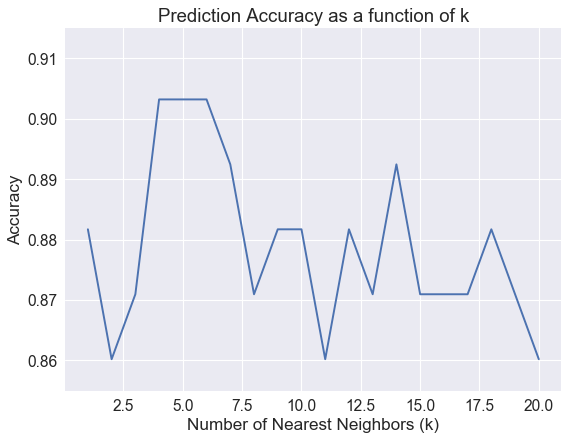

In [14]:
# Plot Accuracy
knn_accuracy = nearest_neighbors.get_accuracy(y_test)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(list(range(1, 21)), knn_accuracy)
plt.title('Prediction Accuracy as a function of k')
plt.xlabel('Number of Nearest Neighbors (k)')
plt.ylabel('Accuracy')
plt.ylim([.855,.915]);

## Logistic Regresssion

#### Implemented 2 gradient methods:  Steepest ascent and Newton's method

In [15]:
class LogsiticRegression(object):
    """Nearest Neighbors Classifier
    
    Parameters
    ----------        
    x_train : {array-like, sparse matrix},
    shape = [n_samples, n_features]
        Training data
    
    y_train : array-like, shape = [n_samples]
        Training targets
    """
    def __init__(self, x_train, y_train):
        x_train[len(y_train)] = 1
        self.x = x_train.as_matrix()
        self.y = pd.DataFrame(y_train[0].replace(0,-1,inplace=False)).as_matrix()
        self.xy = self.y * self.x
        
    def steepestAscent(self, iterations):
        """Compute weights using the steepest ascent algorithm
        
        Parameters
        ----------        
        iterations : Integer,
            Number of iterations to run
        """
        w = np.zeros(shape = (58,1))
        xyw = np.dot(self.xy, w)
        self.objectives = []
        for t in range(1, iterations+1):
            eta = (1/(10**5 * np.sqrt(t+1)))
            w += pd.DataFrame(eta*self.get_gradient(xyw))
            xyw = np.dot(self.xy, w)
            self.objectives.append(self.get_objective(xyw))
        self.w = w
        
    def newtonsMethod(self, iterations):
        """Compute weights using Newton's method
        
        Parameters
        ----------        
        iterations : Integer,
            Number of iterations to run
        """
        w = np.zeros(shape = (58,1))
        xyw = np.dot(self.xy, w)
        self.objectives = []
        for t in range(1, iterations+1):
            eta = (1/(np.sqrt(t+1)))
            gradient = self.get_gradient(xyw)
            
            xw = np.dot(self.x, w)
            
            hessian_inv = np.linalg.inv(pd.DataFrame(self.get_hessian(xw)))
            step = np.dot(hessian_inv, gradient)
            
            w -= pd.DataFrame(eta*step)
            xyw = np.dot(self.xy, w)

            self.objectives.append(self.get_objective(xyw))
        self.w = w
    
    def get_gradient(self, xyw):
        """Compute the gradient
        
        Parameters
        ----------        
        xyw : array-like
            
        Returns
        ---------- 
        grad: array-like
            gradient
        """
        sigs = 1 - scipy.special.expit(xyw)
        grad = np.sum(sigs*self.xy, axis = 0)
        return grad
    
    def get_hessian(self, xw):
        """Compute the Hessian matrix
        
        Parameters
        ----------        
        xw : array-like
            
        Returns
        ---------- 
        hess: array-like
            hessian
        """
        sigmoids = scipy.special.expit(xw)
        sig_product = sigmoids*(1-sigmoids)
        x_product = sig_product.T*self.x.T
        hess = -1*np.dot(x_product, self.x)
        return hess
        
    def get_objective(self, val):
        """Compute the Objective function
        
        Parameters
        ----------        
        val : array-like
            
        Returns
        ---------- 
        obj: float
            Value of objective function
        """
        obj = np.sum(np.ma.log(scipy.special.expit(val)))
        return obj
    
    def predict(self, test_set):
        """Make predictions on the entire test set
        
        test_set : {array-like, sparse matrix},
        shape = [n_samples, n_features]
            Test set to make predictions on
        """
        test_set[57]=1
        sigmoids = scipy.special.expit(np.dot(test_set, self.w))
        self.predictions = [1 if sigmoid >= 0.5 else -1 for sigmoid in sigmoids]

    def get_accuracy(self, test_labels):
        """Compute the accuracy

        Parameters
        ----------
        test_labels : {array-like, sparse matrix},
        shape = [n_samples]
            test labels
            
        Returns
        ----------
        accuracy : Float
            Model accuracy on test set
        """
        test_labels = pd.DataFrame(test_labels[0].replace(0,-1,inplace=False))
        return (self.predictions == test_labels).sum()/len(self.predictions)*100

In [16]:
# Train logistic regression model with steepest ascent algorithm
logistic_regression = LogsiticRegression(x_train, y_train)
logistic_regression.steepestAscent(10000)

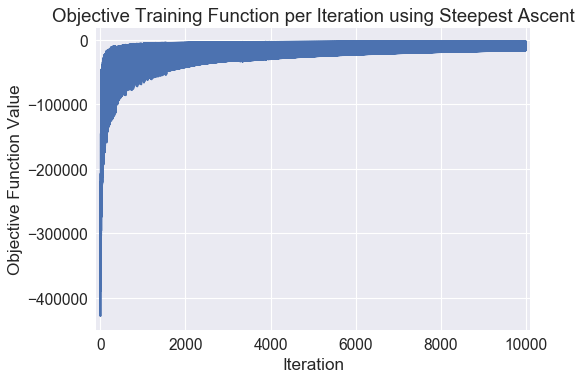

In [17]:
# Plot the objective training function
plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(list(range(1, 10001)), logistic_regression.objectives)
plt.title('Objective Training Function per Iteration using Steepest Ascent')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.xlim([-100,10100]);

In [18]:
# Train logistic regression model with Newton's method
logistic_regression.newtonsMethod(100)
# Predict on the test set
logistic_regression.predict(x_test)

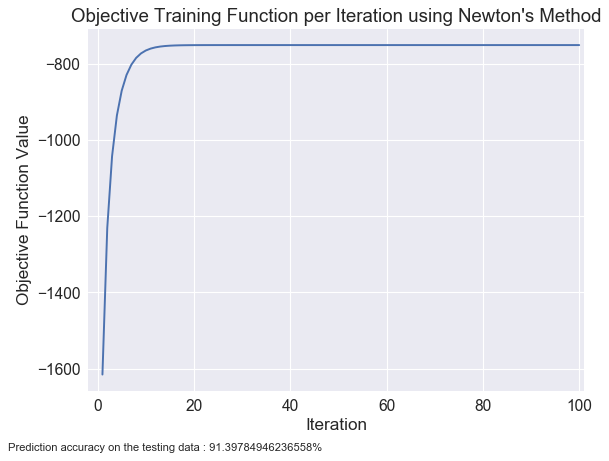

In [19]:
# Plot the objective training function to see difference
logistic_accuracy = logistic_regression.get_accuracy(y_test)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(list(range(1, 101)), logistic_regression.objectives)
plt.title("Objective Training Function per Iteration using Newton's Method")
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.figtext(0.00001, 0.00001, 'Prediction accuracy on the testing data : {0}%'.format(float(logistic_accuracy)), size = 10)
plt.xlim([-2,101]);